### Objetivo:

* **Promover o uso do algoritmo de aprendizado supervisionado SVM, aplicado ao conjunto de dados aleatório;**
<br><br>
* **Aplicar o mesmo algoritmo à base de dados Iris, em 3 diferentes situações: usando a base de dados Iris completa para treinamento e teste, usando a técnica de amostragem hold-out e usando a técnica de busca pela melhor parametrização do modelo GridSearchCV;**
<br><br>
* **Avaliar o desempenho do algoritmo, utilizando**
<br><br>
    * **os próprios rótulos das instâncias das bases de dados;**
<br><br>
    * **o cálculo da métrica de avaliação curva ROC-AUC.**

## Exemplo 1 – Funções de apoio para visualização das classificações

In [1]:
# Importa algumas bibliotecas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# Ignora alguns avisos do numpy
np.seterr(divide='ignore', invalid='ignore');

In [2]:
# Recebe vetores como parâmetro e retorna um vetor com os valores máximo e mínimo
def min_max(*args, margin=0):
    
    res = [] # Armazena os valores máximos e mínimos de cada vetor passado (Ex.: 2 vetores - X, Y)
    
    for arg in args:
        res.append(arg.min() - margin) # Extrai o valor (mínimo - margem) de cada vetor
        res.append(arg.max() + margin) # Extrai o valor (máximo + margem) de cada vetor
        
    return res

In [3]:
# Função de configuração dos plots

# Parâmetros:
# P --> Vetor (array) com 2 atributos previsores
# A --> Vetor (array) com apenas o atributo alvo
# steps --> Valor de escala para cálculo de resolução do gráfico
# mode --> Seleciona a forma de criar um meshgrid: 1=binário; 2=multiclasse
# title --> Titulo da figura a ser criada
# ax_labels --> Dicionário com os rótulos correspondentes ao eixo x e y
# subs --> Tupla com valores para criação de uma figura com subplots

def class_plot_config(P, A, steps, mode, title=None, ax_labels=None, subs=None):
    
    # Cria uma figura para subs = (rows = n° de linhas, cols = n° de colunas, 
    # qntd de figuras (rows + cols))
    if (subs != None):
        
        # Separa cada valor presente na tupla passada para o parâmetro subs
        rows, cols, index = subs
        
        # Cria uma figura, com seus subplots, usando os valores rows, cols e index
        plt.subplot(rows, cols, index)
    
    # Caso subs = None...
    else:
        
        # Não cria nenhuma figura com subplots, apenas exibe a figura criada com a configuração padrão
        plt.show()
        
    # Se title = <título para a figura>, configura um título para a figura
    if (title != None):
        
        plt.title(title)
        
    # Se ax_labels = {'x': <rótulo para x>, 'y': <rótulo para y>}, 
    # configura os rótulos para os eixos x e y
    if (ax_labels != None):
        
        plt.xlabel(ax_labels['x'])
        plt.ylabel(ax_labels['y'])
        
    # Separa o vetor com 2 atributos previsores, 
    # sendo um atributo para cada variável (Px, Py)
    Px, Py = P[:, 0], P[:, 1]
    
    # Exibe a distribuição das distâncias no gráfico
    sns.scatterplot(x=Px, y=Py, hue=A, palette='viridis_r')
    
    # Valores de min - 1 e max + 1 de cada atributo previsor
    min_x, max_x, min_y, max_y = min_max(Px, Py, margin=1)
    
    # Escolhe o menor passo de preenchimento do gráfico (resolução)
    step = np.abs(min([(max_x / min_x) / steps, (max_y / min_y) / steps]))
    
    # Seleciona a forma de criar um meshgrid 
    # meshgrid = 2 arrays de valores, um para a coord x e outro para a coord y, 
    # para a criação de uma grade retangular
    if (mode == 1):
        
        # arrays de coords x e y do meshgrid
        mesh_x, mesh_y = np.meshgrid(np.arange(min_x, max_x, step), np.arange(min_y, max_y, step)) 
    
    # Se mode = 2 (atributo alvo multiclasse)
    else:
        graph = plt.gca() # Acessa o eixo atual da figura(gca = Get the Current Axes)
        
        # Captura os limites míns e máxs dos eixos x e y
        (xmin, xmax), (ymin, ymax) = graph.get_xlim(), graph.get_ylim()
        
        # Arrays de coords x e y
        mesh_x, mesh_y = np.meshgrid(np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps))
    
    # Ajusta o início e fim do gráfico para cada eixo (x,y)
    plt.xlim(min_max(mesh_x))
    plt.ylim(min_max(mesh_y))
    return (mesh_x, mesh_y)

In [4]:
# Utiliza as matrizes meshgrid para buscar as margens e 
# instâncias que se encontram dentro dela para poder destacá-las
def class_plot_2D(model, P, A, steps, title=None, ax_labels=None, subs=None):

    # Recebe as matrizes de coords x e y que refletem as posições de cada pixel no gráfico - meshgrid
    mesh_x, mesh_y = class_plot_config(P, A, steps, 2, title, ax_labels, subs)
    
    # A "decision function" revela de que lado do hiperplano as instâncias estão 
    # (e a que distância estão dele)
    decfun = model.decision_function(P)
    
    # np.where = retorna True para índices de instâncias dentro da margem 
    # As linhas da margem estão distanciadas de -1 e 1 do hiperplano 0)
    
    #svi = np.where((2 * A - 1) * decfun <= 1)[0] # índices das instâncias dentro da margem    
    svi = np.where(np.abs(decfun) <= 1)[0] # índices das instâncias dentro da margem 
    
    sv = P[svi] # Instâncias (valores dos atributos previsores) dentro da margem
    
    # Pontos para plotar as linhas da margem e hiperplano
    # Pontos gerados pelo meshgrid, com os valores máx e mín dos attrs prevs
    C = model.decision_function(np.c_[mesh_x.ravel(), mesh_y.ravel()])
    C = C.reshape(mesh_x.shape)
    
    # Plota linhas da margem (-1,1) e do hiperplano (0)
    ls = ['dotted', 'solid', 'dotted']; # estilos de linha
    lv = [-1, 0, 1]
    plt.contour(mesh_x, mesh_y, C, lv, colors='k', linestyles=ls)
    
    # Cria uma borda ao redor das instâncias dentro da margem
    plt.scatter(sv[:, 0], sv[:, 1], s=100, fc='none', ec='k')

## Exemplo 2 -- Linear SVC aplicado a um conjunto de dados aleatórios

**Com apenas 2 atributos previsores, treina-se um modelo de <font color='red'>SVM</font> com kernel <font color='red'>linear</font>, conhecido como <font color='red'>Linear SVC</font> e utiliza-se a função <font color='red'>class_plot_2D</font> para exibir o resultado da classificação.**

In [5]:
# Cria um conjunto de dados aleatórios com 2 atributos previsores 
# e um atributo alvo y com 2 rótulos (0 e 1)
X, y = datasets.make_blobs(n_samples=80, centers=2, random_state=200) 
attr_names = { 'x': 'X1', 'y': 'X2' }

In [6]:
# Configura e instancia o modelo SVM Linear
model = svm.LinearSVC(C=1, max_iter=10000, random_state=200)

In [7]:
# Treina o modelo SVM linear
model.fit(X, y);

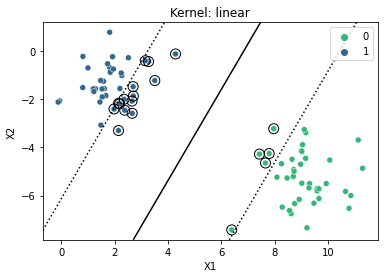

In [8]:
# Exibe o resultado
class_plot_2D(model, X, y, 1000, 'Kernel: linear', attr_names)

* **A figura acima mostra o hiperplano (linha sólida), as suas linhas da margens (linhas tracejadas) e as instâncias usadas para treinamento e teste;**
<br><br>
* **Apesar das instâncias dentro da margem, o vetor converge para uma solução.**
<br><br>
* **O peso dado aos erros de classificação (instâncias dentro das margens) poderia ser aumentado, diminuindo-se o valor do parâmetro C da classe LinearSVC, resultando em uma margem maior e, em alguns casos, poderia ocorrer a não convergência.**

**Ao alterar o *kernel*, usando funções mais complexas como <font color='red'>rbf</font> ou <font color='red'>poly</font>, hiperplanos mais complexos podem ser definidos.**

## Exemplo 3 – SVM com kernel = RBF

In [9]:
# Configura o modelo SVM com Kernel RBF
model = svm.SVC(C=1, gamma='scale', kernel='rbf', max_iter=10000, random_state=200)

In [10]:
# Treina o modelo
model.fit(X, y);

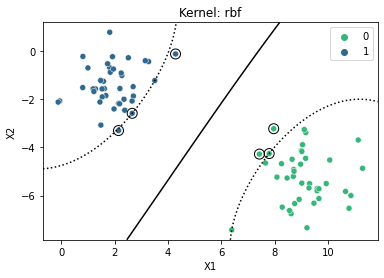

In [11]:
# Exibe o resultado
class_plot_2D(model, X, y, 1000, 'Kernel: rbf', attr_names)

**O hiperplano definido pela função <font color='red'>rbf</font> diverge bastante daquele previsto pela função <font color='red'>linear</font> e claramente ocorre transformação de dimensão. Como mostra a figura acima, as linhas que representam as margens do hiperplano (e o próprio hiperplano) são curvas na dimensão original dos dados.**

## Exemplo 4 – SVM, diferentes proporções de test_size

In [12]:
# Importa a classe para divisão da base de dados em treino e teste
# e a classe para métrica de avaliação do modelo - Curva ROC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay

In [13]:
# Diferentes proporções para os dados de teste (0.1 a 0.9)
treinos = np.arange(0.1, 1, 0.1)

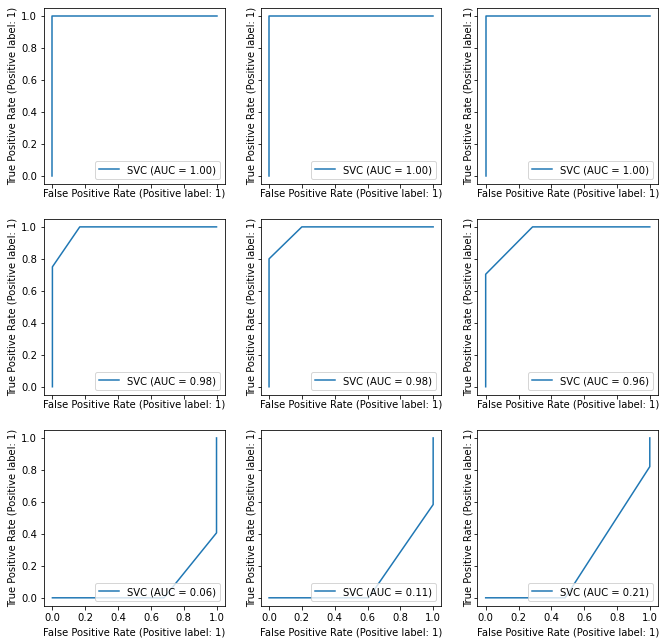

In [14]:
# Configura uma figura com subplots
f, axes = plt.subplots(3, 3, figsize=(11,11), sharex=True, sharey=True)

# Tranforma uma matriz N-Dim em uma matriz 1-Dim com todos os elementos originais
axes = axes.ravel()

# Captura cada índice e proporção para os dados de teste
for i, t in enumerate(treinos):
    
    # Separa os dados em treino e teste
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = t, random_state = 200)
    
    # Configura e instancia o modelo SVM
    model = svm.SVC(C = 100, gamma = 100, kernel = 'rbf', max_iter = 10000, probability = True, random_state = 200)
    
    # Treina o modelo
    model.fit(X_treino, y_treino)
    
    # Plota a curva ROC para diferentes proporções dos dados de treino e teste
    RocCurveDisplay.from_estimator(estimator = model, X = X_teste, y = y_teste, ax = axes[i])

* **Sabendo-se que o intervalo de índices é [0, 8], correspondendo aos percentuais dos dados de teste [10% a 90%], pode-se verificar que, a medida em que se aumenta os conjuntos de testes para a partir de 40%, a classificação começa a ser prejudicada, tornando-se completamente ineficiente a partir dos 70%;**
<br><br>
* **Mesmo se tratando de um conjunto de dados com instâncias bem separadas, a parametrização de <font color='red'>C</font> e <font color='red'>gamma</font> possibilitou a superadaptação, principalmente nas faixas entre 10 a 30% para o conjunto de dados de teste;**
<br><br>
* **Vale lembrar, ainda, que o conjunto de dados é relativamente pequeno, apresentando apenas 80 instâncias ao todo. Se 70% dessas instâncias pertencem ao conjunto de testes, restam apenas 24 instâncias para o conjunto de treinamento. De qualquer forma, se utilizados outros valores para C e gamma, o algoritmo poderia ser capaz de classificar as instâncias de maneira adequada mesmo com quantidades ainda menores de instâncias.**

## Problemas multiclasses

**Para visualizar as classificações de múltiplas classes, serão utilizadas a função de configuração de plotagem <font color='red'>class_plot_config</font> e a função <font color='red'>min_max</font> do Exemplo 1. Uma vez que as relações se tornarão mais complexas às margens, o algoritmo, dessa vez, apresentará as regiões de cada categoria, colorindo o fundo.**

### Exemplo 5 – Função para plotar multiclasse

In [15]:
def multiclass_plot_2D(model, P, T, steps, title=None, ax_labels=None, subs=None):
    # Recebe a matriz que reflete as posições de cada pixel no gráfico
    mesh_x, mesh_y = class_plot_config(P, T, steps, 1, title, ax_labels, subs)
    
    # Achata as matrizes X/Y. A nova matriz terá cada coluna como um eixo
    ravel_xx_yy = np.c_[mesh_x.ravel(), mesh_y.ravel()]
    
    # Classifica cada pixel do gráfico segundo o modelo treinado
    C = model.predict(X=ravel_xx_yy).reshape(mesh_x.shape)
    
    # Define a cor de cada pixel conforme a classificação prevista
    plt.contourf(mesh_x, mesh_y, C, cmap='viridis_r', alpha=0.2)

**A função <font color='red'>multiclass_plot_2D</font> plota as instâncias, cada classe com uma cor, e colore todos os demais pixels do gráfico, evidenciando os hiperplanos de separação.**
<br><br>
**O Exemplo 6, a seguir, exibe a classificação do conjunto de dados Iris do SciKit-Learn.**
<br><br>
**2 atributos do conjunto (comprimento das sépalas e pétalas) são selecionados para serem atributos previsores. Esse conjunto possui 3 categorias para o atributo alvo para as espécies de flor: setosa, versicolor e virginica.**

### Exemplo 6 – Treinamento e exibição de um SVM Linear

In [16]:
# Importa a classe datasets
from sklearn import datasets as ds

In [17]:
# Carrega o conjunto de dados Iris
conj = ds.load_iris()

In [18]:
# Seleciona os atributos: Comprimento de Sépalas/Pétalas
X = np.c_[conj['data'][:, 0], conj['data'][:, 2]]

In [19]:
# Seleciona o atributo alvo e substitui seus rótulos de númericos por strings
y = conj['target']
y_named = [conj['target_names'][t] for t in y]

In [20]:
# Rótulos para os eixos x e y da figura
attr_names = {'x': 'Comprimento das Sépalas (cm)', 'y': 'Comprimento das Pétalas (cm)'}

In [21]:
# Instancia o modelo SVM linear
model = svm.LinearSVC(max_iter=10000)

In [22]:
# Procede com o treinamento
model.fit(X, y);

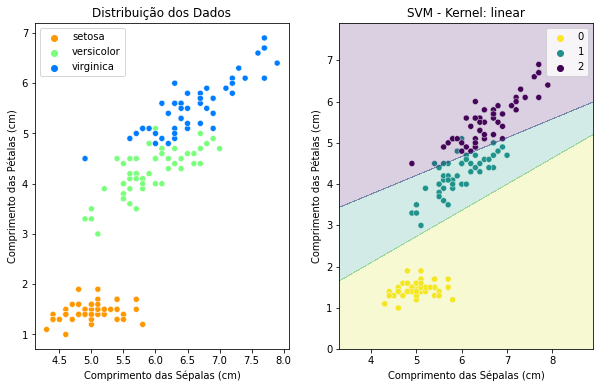

In [23]:
f, axes = plt.subplots(1,2,figsize=(10,6))
axes = axes.ravel()

# Exibe as classificações
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_named, palette='jet_r', ax=axes[0])
axes[0].set_title('Distribuição dos Dados') # Config um título para a figura
axes[0].set_xlabel(attr_names['x']) # Config um rótulo para o eixo x
axes[0].set_ylabel(attr_names['y']) # Config um rótulo para o eixo y
multiclass_plot_2D(model, X, y, 1000, 'SVM - Kernel: linear', attr_names, (1,2,2)); # Plota a figura

* **Pode-se observar que existem instâncias da categoria 1 (versicolor) classificadas incorretamente na categoria 2 (vírginica).**
<br><br>
* **Devido à baixa quantidade de instâncias sobrepostas, como pode ser notado na figura acima, era previsível que o kernel linear obtivesse um bom desempenho.**
<br><br>
* **É possível que uma classificação mais precisa pudesse ser obtida com um algoritmo de SVM não linear, no entanto, vale lembrar que essa condição aumenta as chances de *overfitting*.**
<br><br>
* **Para tentar melhorar a separação entre as espécies, a ferramenta de varredura de hiperparâmetros denominada GridSearchCV será utilizada a seguir.**
<br><br>
* **Essa ferramenta permite que o programador informe todos os hiperparâmetros que se deseja testar e avaliar todas as combinações possíveis desses hiperparâmetros, escolhendo a métrica desejada.**

### Exemplo 7 – Implementação do GridSearchCV - Em busca de hiperparâmetros adequados para o SVM

**Nessa seção, é implementado o algoritmo <font color='red'>GridSearchCV</font> com três kernels diferentes (linear, poly e rbf) e alguns valores de parametrização para C e gamma. Todos esses hiperparâmetros são fornecidos por meio de um dicionário. O método de avaliação escolhido é a curva ROC - AUC com estratégia multiclasse um contra todos (<font color='red'>roc_auc_ovr</font>).**

In [24]:
# Importa a classe para a implementação do Grid Search
from sklearn.model_selection import GridSearchCV

In [25]:
# Alguns valores para o hiperparâmetro C
Cs = [1, 10, 100, 1000]

In [26]:
# Alguns valores para o hiperparâmetro gamma
gammas = [1e-1, 1e-2, 1e-3, 1e-4]

In [27]:
params_list = [
    {'kernel': ['linear'], 'C': Cs},
    {'kernel': ['poly'], 'C': Cs, 'gamma': gammas},
    {'kernel': ['rbf'], 'C': Cs, 'gamma': gammas}]

In [28]:
# Configura o Grid Search com a lista de hiperparâmetros a serem testados
model = GridSearchCV(svm.SVC(probability=True, max_iter=1000000, random_state=200), 
                     params_list, scoring='roc_auc_ovr')

In [29]:
# Treina o modelo com aplicação do Grid Search
model.fit(X, y);

In [30]:
# Exibe os melhores parâmetros
print('Melhores parâmetros: {0}\n'.format(model.best_params_))

Melhores parâmetros: {'C': 10, 'kernel': 'linear'}



In [31]:
# Armazena alguns valores fornecidos pelo modelo
params_set = model.cv_results_['params'] # 36 combinações diferentes dos hiperparâmetros de teste
medias = model.cv_results_['mean_test_score'] # 36 médias das notas (scores) de cada teste
ranks = model.cv_results_['rank_test_score'] # 36 posições (ranks) para as notas dos testes
desvios = model.cv_results_['std_test_score'] # 36 valores de desvios-padrões

In [32]:
# Forma tuplas com cada valor de cada variável definida na linha anterior
zipped = zip(ranks, medias, desvios, params_set)

# Organiza as tuplas pelo valor do rank - valor na posição 0 de cada tupla
sorted_zip = sorted(zipped, key = lambda x: x[0])

In [33]:
# Exibe algumas tuplas organizadas na variável sorted_zip
print(sorted_zip[0:5])

[(1, 0.9956666666666667, 0.0059254629448770675, {'C': 10, 'kernel': 'linear'}), (2, 0.9949999999999999, 0.00557773351022718, {'C': 1000, 'kernel': 'linear'}), (2, 0.9949999999999999, 0.007149203529842441, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}), (2, 0.9949999999999999, 0.00557773351022718, {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}), (5, 0.9946666666666666, 0.005715476066494097, {'C': 100, 'kernel': 'linear'})]


In [34]:
# Exibe os 5 primeiros valores da variável sorted_zip de forma organizada
for rank, media, desvio, params in sorted_zip[0:5]:
    print('Ranking: {0:0.4f} - Média: {1:0.04f} - Desvio: {2:0.04f} – Parâmetros {3}'.format(rank, media, desvio, params))

Ranking: 1.0000 - Média: 0.9957 - Desvio: 0.0059 – Parâmetros {'C': 10, 'kernel': 'linear'}
Ranking: 2.0000 - Média: 0.9950 - Desvio: 0.0056 – Parâmetros {'C': 1000, 'kernel': 'linear'}
Ranking: 2.0000 - Média: 0.9950 - Desvio: 0.0071 – Parâmetros {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Ranking: 2.0000 - Média: 0.9950 - Desvio: 0.0056 – Parâmetros {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Ranking: 5.0000 - Média: 0.9947 - Desvio: 0.0057 – Parâmetros {'C': 100, 'kernel': 'linear'}


* **O objetivo do algoritmo GridSearchCV, nessa seção, foi treinar o modelo SVM, a partir dos hiperparâmetros fornecidos e retornar os valores médios e de desvio-padrão, segundo o critério de avaliação selecionado, nesse caso, a ROC-AUC.**
<br><br>
* **Os vetores contendo esses valores médios e de desvio-padrão são agrupados com o método zip para serem iterados simultaneamente.**
<br><br>
* **Esse grupo de vetores é ordenado pela ordem de melhor avaliação (ranks) e os valores mensurados são exibidos na tela, bem como os hiperparâmetros a que se referem, facilitando a determinação dos parâmetros mais adequados.**